In [1]:
# In[]

from bs4 import BeautifulSoup as bs
import pandas as pd
import urllib
import re
import matplotlib.pyplot as plt
import numpy as np
import requests

In [2]:
""" first scrape all xlsx from boulder county residential sales """
url = "https://www.bouldercounty.org/property-and-land/assessor/sales/comps-2019/residential/"
page = requests.get(url)

soup = bs(page.content)
# In[]
XLSX_links = [i.get('href') for i in soup.findAll('a', attrs={'href':re.compile("^https://assessor")}) if "XLSX" in i]

for i, url in enumerate(XLSX_links):
    if i < 10:
        doc = "0" + str(i)
    else:
        doc = str(i)
        
    name = "BC_XLSX_" + doc + ".xlsx"
    urllib.request.urlretrieve(url, name)

In [3]:
# In[]
""" create a dict of all data frames to check if they have the same columns """
dfs = {}

for i in range(len(XLSX_links)):
    if i < 10:
        doc = "0" + str(i)
    else:
        doc = str(i)
    
    name = "df_" + doc
    name_old = "BC_XLSX_" + doc + ".xlsx"
    df =     pd.read_excel(name_old)
    dfs.update({name : df})
"""save the names because you'll need them"""
names = []
for i in range(len(XLSX_links)):
    if i < 10:
        doc = "0" + str(i)
    else:
        doc = str(i)
    
    name = "df_" + doc
    names.append(name)
    
for name in names:
    print(dfs[name].columns)

Index(['Account Number', 'Class', 'Market Area', 'Property Address', 'City',
       'Total Units', 'Total Bdrms', 'Above Grade SF', 'Bsmt Fin SF',
       'Bsmt Unfin SF', 'Garage Spaces', 'Uncovrd Pkg Spc', 'Quality',
       'Eff Yr Blt', 'Reception No', 'Sale Date', 'Sale Price',
       'Time Adj Sale Price'],
      dtype='object')
Index(['Account Number', 'Property Type', 'Property Address Street Number',
       'Property Address Street Dir', 'Property Address Street Name',
       'Property Address Street Suffix', 'Property Address Unit Number',
       'Location', 'Design', 'Quality', 'Eff Yr Built', 'Above Grd SF',
       'Basemt Tot SF', 'Basemt Fin SF', 'Basemt Unf SF', 'Garage Type',
       'Garage SF', 'Est Land SF', 'Reception No', 'Distrss Sale',
       'Sale Date Mon YR', 'Sale Price', 'Time Adjust Sales Price',
       'Market Area'],
      dtype='object')
Index(['Account Number', 'Property Type', 'Property Address Street Number',
       'Property Address Street Dir', 'Proper

In [4]:
# In[]
name_ref = set(dfs['df_00'].columns)

for name in names[1:]:
    print(set(dfs[name].columns).difference(name_ref))


name_ref2 = set(dfs['df_01'].columns)
for name in names[2:]:
    print(set(dfs[name].columns).difference(name_ref2), name_ref2.difference(set(dfs[name].columns)))
""" df_01 thru df_31 all have the same columns, potentially not in order"""

"""there are 3 sets of columns:
    df_00's columns (apartments), 
    df_01-df_31's columns
    df_32's columns (manufactured housing)
"""

{'Design', 'Distrss Sale', 'Est Land SF', 'Garage SF', 'Basemt Fin SF', 'Basemt Tot SF', 'Property Type', 'Eff Yr Built', 'Property Address Unit Number', 'Sale Date Mon YR', 'Location', 'Time Adjust Sales Price', 'Property Address Street Dir', 'Basemt Unf SF', 'Property Address Street Name', 'Property Address Street Number', 'Above Grd SF', 'Garage Type', 'Property Address Street Suffix'}
{'Design', 'Distrss Sale', 'Est Land SF', 'Garage SF', 'Basemt Fin SF', 'Basemt Tot SF', 'Property Type', 'Eff Yr Built', 'Property Address Unit Number', 'Sale Date Mon YR', 'Location', 'Time Adjust Sales Price', 'Property Address Street Dir', 'Basemt Unf SF', 'Property Address Street Name', 'Property Address Street Number', 'Above Grd SF', 'Garage Type', 'Property Address Street Suffix'}
{'Design', 'Distrss Sale', 'Est Land SF', 'Garage SF', 'Basemt Fin SF', 'Basemt Tot SF', 'Property Type', 'Eff Yr Built', 'Property Address Unit Number', 'Sale Date Mon YR', 'Location', 'Time Adjust Sales Price', 'Pr

"there are 3 sets of columns:\n    df_00's columns (apartments), \n    df_01-df_31's columns\n    df_32's columns (manufactured housing)\n"

In [5]:
# In[]
print(XLSX_links[0])
print(XLSX_links[32])
""" I'll just use the ones where the columns match up, which include
    single family homes, townhomes, and condos
"""

main_df = dfs['df_01']
for name in names[2:len(names)-1]:
    main_df = main_df.append(dfs[name], ignore_index=True)

print(main_df.shape)
print(main_df.columns)

print(main_df.dtypes)

https://assessor.boco.solutions/enov/asr_docs/ar-comp-2019-apartments-sheet.xlsx
https://assessor.boco.solutions/enov/asr_docs/ar-comp-2019-mh-sheet.xlsx
(30487, 24)
Index(['Account Number', 'Property Type', 'Property Address Street Number',
       'Property Address Street Dir', 'Property Address Street Name',
       'Property Address Street Suffix', 'Property Address Unit Number',
       'Location', 'Design', 'Quality', 'Eff Yr Built', 'Above Grd SF',
       'Basemt Tot SF', 'Basemt Fin SF', 'Basemt Unf SF', 'Garage Type',
       'Garage SF', 'Est Land SF', 'Reception No', 'Distrss Sale',
       'Sale Date Mon YR', 'Sale Price', 'Time Adjust Sales Price',
       'Market Area'],
      dtype='object')
Account Number                            object
Property Type                             object
Property Address Street Number             int64
Property Address Street Dir               object
Property Address Street Name              object
Property Address Street Suffix            obj

In [6]:
# In[]
"""
Above Grd SF, Basemt Tot SF, Basemt Fin SF, Basemt Unf SF, Garage SF, Est Land SF, Sale Price, Time Adjust Sales Price
should all be numeric fields, not object
"""
print(main_df.describe())
main_df['Distrss Sale'].head()
cvrt_num = ['Above Grd SF', 'Basemt Tot SF', 'Basemt Fin SF', 'Basemt Unf SF', 'Garage SF', 'Est Land SF', 'Sale Price', 'Time Adjust Sales Price']

for name in cvrt_num:
    main_df[name] = pd.to_numeric(main_df[name].str.replace(",", "").str.replace("$",""))

print(main_df.dtypes)
print(main_df.describe())

       Property Address Street Number  Eff Yr Built   Market Area
count                    30487.000000  30487.000000  30487.000000
mean                      2207.407256   1993.910093    414.422803
std                       2489.406353     15.728842    170.322707
min                          0.000000   1880.000000    101.000000
25%                        745.000000   1984.000000    304.000000
50%                       1505.000000   1996.000000    407.000000
75%                       2855.000000   2005.000000    507.000000
max                      51914.000000   2018.000000    634.000000
Account Number                            object
Property Type                             object
Property Address Street Number             int64
Property Address Street Dir               object
Property Address Street Name              object
Property Address Street Suffix            object
Property Address Unit Number              object
Location                                  object
Design        

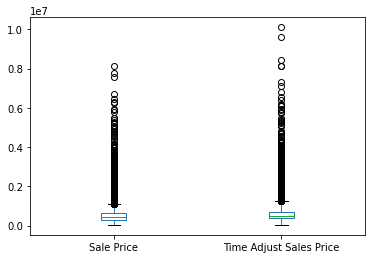

0.6366652432414677


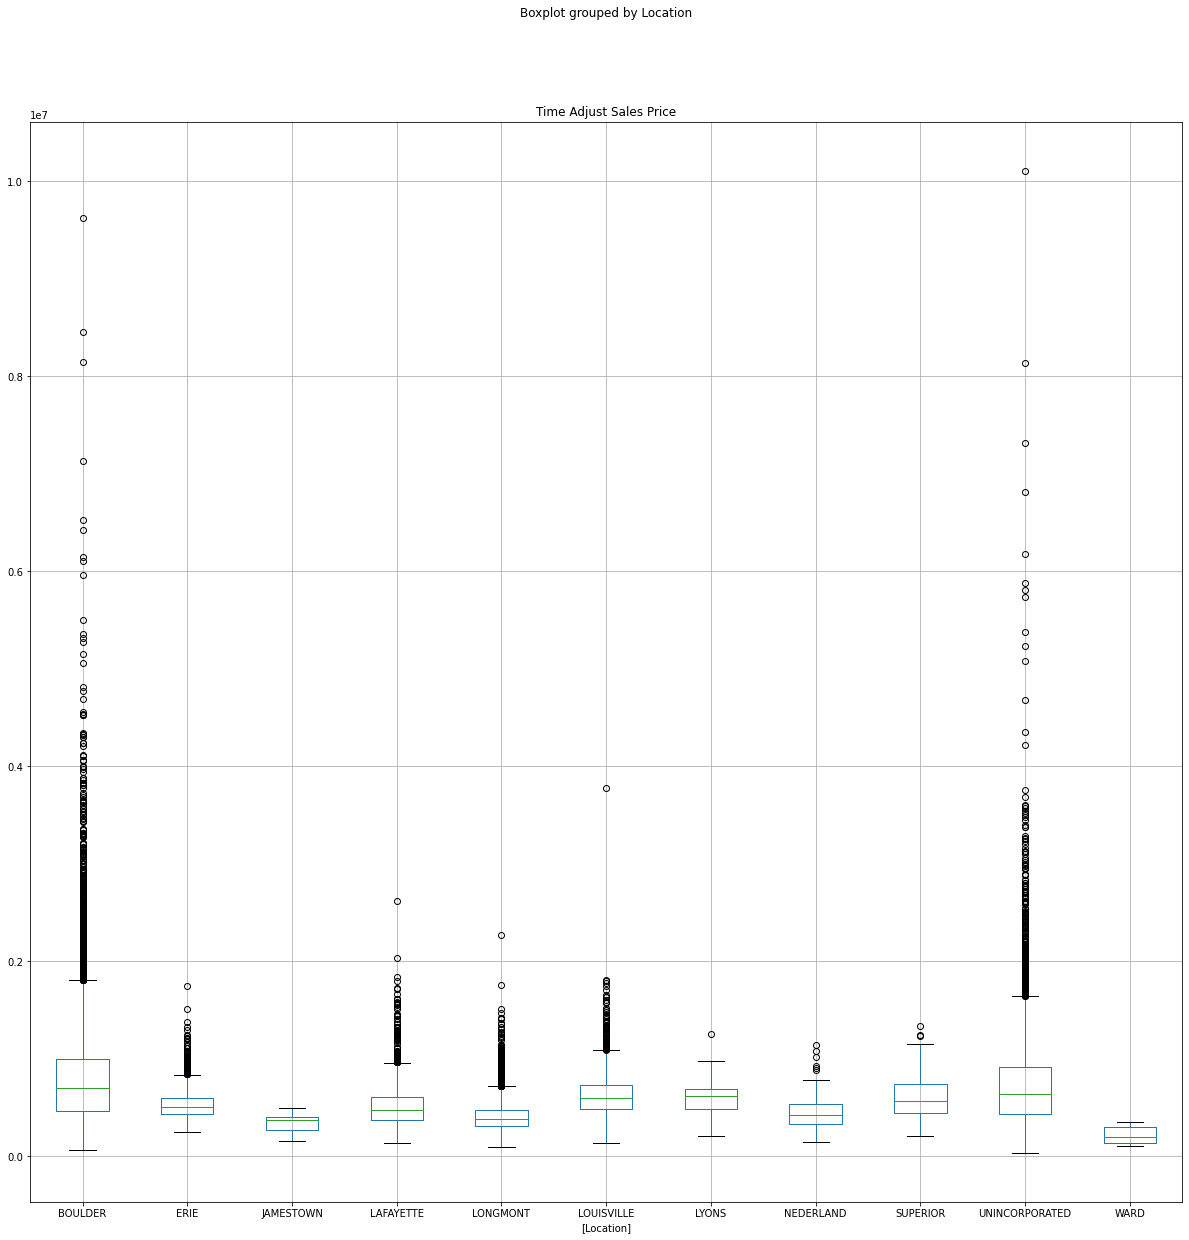

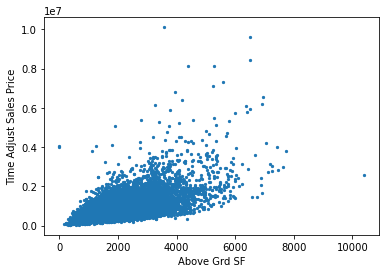

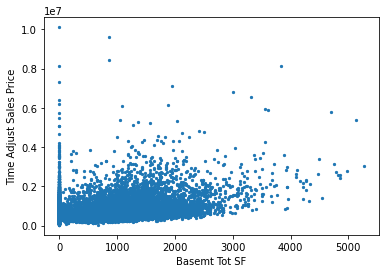

In [7]:
# In[]
main_df[['Sale Price','Time Adjust Sales Price']].plot(kind='box')
plt.show()
#### HUGE amount of outliers, very non-linear

main_df[['Location','Time Adjust Sales Price']].boxplot(by='Location',figsize=(20,20))
# many large outliers in boulder proper and unincorporated (no suprise)

main_df[['Above Grd SF','Time Adjust Sales Price']].plot(x='Above Grd SF',
       y='Time Adjust Sales Price', marker='.', kind='scatter')

main_df[['Basemt Tot SF','Time Adjust Sales Price']].plot(x='Basemt Tot SF',
       y='Time Adjust Sales Price', marker='.', kind='scatter')

print(
main_df[main_df['Basemt Tot SF'] > 0]['Basemt Tot SF'].count() / main_df['Basemt Tot SF'].count()
)
# ~64% of homes have a basement

In [8]:
# In[]
"""
Cleaning up the data
fill in NAs with best choice depending on field
"""
print(main_df.isna().sum())
# most with no land are condos. OK to set nas in land sf to 0
print(main_df[main_df['Est Land SF'].isna()].groupby(['Property Type']).count())

main_df[main_df['Above Grd SF'].isna()]

main_df['Est Land SF'] = main_df['Est Land SF'].fillna(0)

print(main_df[main_df['Garage SF'].isna()].groupby(['Garage Type'])['Garage Type'].count())
# Garage with no value not always "None". I'll just forward fill but there is probably a better way to do it

Account Number                        0
Property Type                         0
Property Address Street Number        0
Property Address Street Dir       28151
Property Address Street Name          0
Property Address Street Suffix      333
Property Address Unit Number      24823
Location                              0
Design                                0
Quality                               0
Eff Yr Built                          0
Above Grd SF                         12
Basemt Tot SF                        44
Basemt Fin SF                        44
Basemt Unf SF                       271
Garage Type                           0
Garage SF                          8674
Est Land SF                        5757
Reception No                          0
Distrss Sale                          0
Sale Date Mon YR                      0
Sale Price                            3
Time Adjust Sales Price              54
Market Area                           0
dtype: int64
               Account Numb

In [9]:
# In[]
# first update garage type None with NA sq f to 0 sq f
update_0 = (main_df['Garage Type'] == 'None') & (main_df['Garage SF'].isna())
main_df['Garage SF'] = np.where(update_0, 0, main_df['Garage SF'])
#forward fill the rest
main_df['Garage SF'] = main_df['Garage SF'].fillna(method='ffill')
print(main_df.isna().sum())

Account Number                        0
Property Type                         0
Property Address Street Number        0
Property Address Street Dir       28151
Property Address Street Name          0
Property Address Street Suffix      333
Property Address Unit Number      24823
Location                              0
Design                                0
Quality                               0
Eff Yr Built                          0
Above Grd SF                         12
Basemt Tot SF                        44
Basemt Fin SF                        44
Basemt Unf SF                       271
Garage Type                           0
Garage SF                             0
Est Land SF                           0
Reception No                          0
Distrss Sale                          0
Sale Date Mon YR                      0
Sale Price                            3
Time Adjust Sales Price              54
Market Area                           0
dtype: int64


In [10]:
# In[]
# Update na basement sf to zero
Basemt = ['Basemt Tot SF', 'Basemt Fin SF', 'Basemt Unf SF']
for b in Basemt:
    main_df[b] = main_df[b].fillna(0)


print(main_df.isna().sum())

Account Number                        0
Property Type                         0
Property Address Street Number        0
Property Address Street Dir       28151
Property Address Street Name          0
Property Address Street Suffix      333
Property Address Unit Number      24823
Location                              0
Design                                0
Quality                               0
Eff Yr Built                          0
Above Grd SF                         12
Basemt Tot SF                         0
Basemt Fin SF                         0
Basemt Unf SF                         0
Garage Type                           0
Garage SF                             0
Est Land SF                           0
Reception No                          0
Distrss Sale                          0
Sale Date Mon YR                      0
Sale Price                            3
Time Adjust Sales Price              54
Market Area                           0
dtype: int64


In [11]:
# In[]
# use only fields you want to move forward with
fields = ['Property Type','Location','Design','Quality','Eff Yr Built','Above Grd SF',
          'Basemt Tot SF','Basemt Fin SF','Basemt Unf SF','Garage Type',
          'Garage SF','Est Land SF','Distrss Sale','Sale Date Mon YR',
          'Market Area','Time Adjust Sales Price']

main_df = main_df[fields].dropna()
print(main_df.shape)
print(main_df.columns)

(30422, 16)
Index(['Property Type', 'Location', 'Design', 'Quality', 'Eff Yr Built',
       'Above Grd SF', 'Basemt Tot SF', 'Basemt Fin SF', 'Basemt Unf SF',
       'Garage Type', 'Garage SF', 'Est Land SF', 'Distrss Sale',
       'Sale Date Mon YR', 'Market Area', 'Time Adjust Sales Price'],
      dtype='object')


In [12]:
# In[]
"""
add in date fields
"""
main_df['SaleYR'] = main_df['Sale Date Mon YR'].dt.year
main_df['SaleMO'] = main_df['Sale Date Mon YR'].dt.month
#one home shows negative 1 age so clip at zero
main_df['HomeAge'] = (main_df.SaleYR - main_df['Eff Yr Built']).clip(lower=0)

main_df.drop(['Eff Yr Built','Sale Date Mon YR'], axis=1,inplace=True)

In [13]:
# In[]
######### one hot encode categorical variables
Dummies = ['Property Type','Location','Design','Quality',
           'Garage Type','Distrss Sale','Market Area','SaleYR',
           'SaleMO']

main_df[Dummies].dtypes
for dum in Dummies[-3:]:
    main_df[dum] = main_df[dum].astype(str)

In [14]:
# In[]
one_hot = pd.get_dummies(main_df[Dummies])

main_df = pd.concat([main_df, one_hot], axis=1)
main_df.shape

main_df.drop(Dummies, axis=1, inplace=True)

In [15]:
# In[]
""" now ready to split data into predictors and target """
# In[]
target = main_df['Time Adjust Sales Price']
predictors = main_df.drop(['Time Adjust Sales Price'], axis=1)
print(target.shape)
print(predictors.shape)

(30422,)
(30422, 106)


In [16]:
from sklearn.model_selection import train_test_split

predictors = np.array(predictors)
target = np.array(target)

X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.25, random_state=50)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


model_1 = Sequential()
n_cols = predictors.shape[1]
#first model start out with one hidden layer with 50 nodes
model_1.add(Dense(50, activation='relu', input_shape=(n_cols,)))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mean_squared_error')

early_stopping_monitor = EarlyStopping(patience=3)

model_1_training = model_1.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])

Train on 15971 samples, validate on 6845 samples
Epoch 1/30
15971/15971 [==============================] - 2s 95us/sample - loss: 621704745850.1895 - val_loss: 501151668403.8171
Epoch 2/30
15971/15971 [==============================] - 1s 58us/sample - loss: 567182004988.5217 - val_loss: 482137639157.0419
Epoch 3/30
15971/15971 [==============================] - 1s 62us/sample - loss: 527576906332.6159 - val_loss: 465375134935.8703
Epoch 4/30
15971/15971 [==============================] - 1s 60us/sample - loss: 496982501952.6612 - val_loss: 445819344585.1348
Epoch 5/30
15971/15971 [==============================] - 1s 62us/sample - loss: 471105273978.0773 - val_loss: 423454635097.6094
Epoch 6/30
15971/15971 [==============================] - 1s 56us/sample - loss: 438726445643.4327 - val_loss: 393190225270.4444
Epoch 7/30
15971/15971 [==============================] - 1s 60us/sample - loss: 407328659819.5389 - val_loss: 361439531081.6024
Epoch 8/30
15971/15971 [========================

In [18]:
model_2 = Sequential()
#second model two hidden layer with 50 nodes
model_2.add(Dense(50, activation='relu', input_shape=(n_cols,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

early_stopping_monitor = EarlyStopping(patience=3)

model_2_training = model_2.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])

Train on 15971 samples, validate on 6845 samples
Epoch 1/30
15971/15971 [==============================] - 2s 135us/sample - loss: 565600061986.3984 - val_loss: 450170498713.5627
Epoch 2/30
15971/15971 [==============================] - 1s 70us/sample - loss: 470526489460.5472 - val_loss: 332078799879.9287
Epoch 3/30
15971/15971 [==============================] - 1s 73us/sample - loss: 332685242604.3323 - val_loss: 228707427121.4048
Epoch 4/30
15971/15971 [==============================] - 1s 73us/sample - loss: 208193938535.0989 - val_loss: 159857676217.9880
Epoch 5/30
15971/15971 [==============================] - 1s 70us/sample - loss: 160227376701.6477 - val_loss: 137473423080.2513
Epoch 6/30
15971/15971 [==============================] - 2s 99us/sample - loss: 152851350364.6960 - val_loss: 132237788809.1068
Epoch 7/30
15971/15971 [==============================] - 2s 95us/sample - loss: 145230018101.8256 - val_loss: 128589276975.4600
Epoch 8/30
15971/15971 [=======================

In [19]:
model_3 = Sequential()
#3rd model add more nodes
model_3.add(Dense(250, activation='relu', input_shape=(n_cols,)))
model_3.add(Dense(250, activation='relu'))
model_3.add(Dense(1))
model_3.compile(optimizer='adam', loss='mean_squared_error')


model_3_training = model_3.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])

Train on 15971 samples, validate on 6845 samples
Epoch 1/30
15971/15971 [==============================] - 4s 224us/sample - loss: 369979148146.9443 - val_loss: 176876168485.6613
Epoch 2/30
15971/15971 [==============================] - 3s 180us/sample - loss: 191190471960.1237 - val_loss: 137482420834.3608
Epoch 3/30
15971/15971 [==============================] - 2s 150us/sample - loss: 174062840441.3399 - val_loss: 128709430650.3340
Epoch 4/30
15971/15971 [==============================] - 2s 153us/sample - loss: 148232133730.2902 - val_loss: 118303584224.2852
Epoch 5/30
15971/15971 [==============================] - 2s 145us/sample - loss: 145505087595.9717 - val_loss: 113831498780.5733
Epoch 6/30
15971/15971 [==============================] - 3s 192us/sample - loss: 127739617506.8432 - val_loss: 116899901457.3534
Epoch 7/30
15971/15971 [==============================] - 2s 145us/sample - loss: 123264716607.1064 - val_loss: 101123986952.4523
Epoch 8/30
15971/15971 [=================

In [20]:
model_4 = Sequential()
#4th model in between
model_4.add(Dense(150, activation='relu', input_shape=(n_cols,)))
model_4.add(Dense(150, activation='relu'))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mean_squared_error')


model_4_training = model_4.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])

Train on 15971 samples, validate on 6845 samples
Epoch 1/30
15971/15971 [==============================] - 3s 159us/sample - loss: 605853246785.4146 - val_loss: 270594910846.7845
Epoch 2/30
15971/15971 [==============================] - 2s 108us/sample - loss: 254318979647.8918 - val_loss: 146322924033.4212
Epoch 3/30
15971/15971 [==============================] - 2s 105us/sample - loss: 151811005979.6661 - val_loss: 129152222486.1031
Epoch 4/30
15971/15971 [==============================] - 2s 112us/sample - loss: 144447921494.8294 - val_loss: 119788255868.9893
Epoch 5/30
15971/15971 [==============================] - 2s 104us/sample - loss: 137815803858.2210 - val_loss: 123563266672.1239
Epoch 6/30
15971/15971 [==============================] - 3s 184us/sample - loss: 133300880462.7988 - val_loss: 116399375623.7417
Epoch 7/30
15971/15971 [==============================] - 2s 121us/sample - loss: 125140576423.0868 - val_loss: 114529239686.2644
Epoch 8/30
15971/15971 [=================

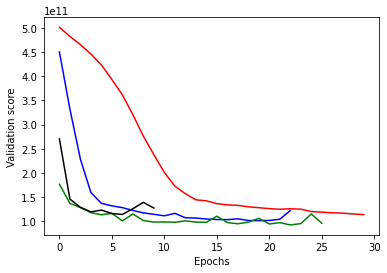

In [21]:
plt.plot(model_1_training.history['val_loss'], 'r', model_2_training.history['val_loss'], 'b', 
         model_3_training.history['val_loss'], 'g', model_4_training.history['val_loss'], 'black')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [22]:
print(model_1.evaluate(x=X_test, y=y_test)** 0.5)
print(model_2.evaluate(x=X_test, y=y_test)** 0.5)
print(model_3.evaluate(x=X_test, y=y_test)** 0.5)
print(model_4.evaluate(x=X_test, y=y_test)** 0.5)

7606/7606 [==============================] - 1s 122us/sample - loss: 119581332824.9235
345805.3394974165
7606/7606 [==============================] - 1s 102us/sample - loss: 136839043409.6534
369917.61705770844
7606/7606 [==============================] - 1s 170us/sample - loss: 104954729620.3629
323967.1736771534
7606/7606 [==============================] - 2s 209us/sample - loss: 134721892217.3694
367044.8095496917


In [23]:
"""try again with mean absolute error"""
"""
mean squared error will be more sensitive to the outliers
"""
model_1 = Sequential()
n_cols = predictors.shape[1]
#first model start out with one hidden layer with 50 nodes
model_1.add(Dense(50, activation='relu', input_shape=(n_cols,)))
model_1.add(Dense(1))
model_1.compile(optimizer='adam', loss='mean_absolute_error')

early_stopping_monitor = EarlyStopping(patience=3)

model_1_training = model_1.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])
model_2 = Sequential()
#second model two hidden layer with 50 nodes
model_2.add(Dense(50, activation='relu', input_shape=(n_cols,)))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(1))
model_2.compile(optimizer='adam', loss='mean_absolute_error')

early_stopping_monitor = EarlyStopping(patience=3)

model_2_training = model_2.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])

model_3 = Sequential()
#3rd model add more nodes
model_3.add(Dense(250, activation='relu', input_shape=(n_cols,)))
model_3.add(Dense(250, activation='relu'))
model_3.add(Dense(1))
model_3.compile(optimizer='adam', loss='mean_absolute_error')


model_3_training = model_3.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])

model_4 = Sequential()
#4th model in between
model_4.add(Dense(150, activation='relu', input_shape=(n_cols,)))
model_4.add(Dense(150, activation='relu'))
model_4.add(Dense(1))
model_4.compile(optimizer='adam', loss='mean_absolute_error')


model_4_training = model_4.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])

Train on 15971 samples, validate on 6845 samples
Epoch 1/30
15971/15971 [==============================] - 6s 370us/sample - loss: 589542.1809 - val_loss: 561679.1280
Epoch 2/30
15971/15971 [==============================] - 6s 403us/sample - loss: 542183.7452 - val_loss: 496579.9735
Epoch 3/30
15971/15971 [==============================] - 5s 321us/sample - loss: 459382.5177 - val_loss: 393333.5881
Epoch 4/30
15971/15971 [==============================] - 5s 319us/sample - loss: 333499.1629 - val_loss: 270942.0117
Epoch 5/30
15971/15971 [==============================] - 3s 192us/sample - loss: 252522.2874 - val_loss: 235786.5086
Epoch 6/30
15971/15971 [==============================] - 4s 223us/sample - loss: 234508.6169 - val_loss: 226415.1181
Epoch 7/30
15971/15971 [==============================] - 4s 223us/sample - loss: 227457.3395 - val_loss: 220827.6326
Epoch 8/30
15971/15971 [==============================] - 3s 190us/sample - loss: 220907.0153 - val_loss: 214640.9944
Epoch 9

Epoch 11/30
15971/15971 [==============================] - 4s 238us/sample - loss: 182566.9035 - val_loss: 204179.9985
Epoch 12/30
15971/15971 [==============================] - 2s 145us/sample - loss: 184238.3773 - val_loss: 175944.8207
Epoch 13/30
15971/15971 [==============================] - 2s 139us/sample - loss: 179806.9955 - val_loss: 175698.6248
Epoch 14/30
15971/15971 [==============================] - 3s 172us/sample - loss: 178040.5478 - val_loss: 174255.4447
Epoch 15/30
15971/15971 [==============================] - 2s 151us/sample - loss: 176435.8356 - val_loss: 174047.2143
Epoch 16/30
15971/15971 [==============================] - 2s 130us/sample - loss: 176071.5457 - val_loss: 173201.7848
Epoch 17/30
15971/15971 [==============================] - 2s 128us/sample - loss: 176563.8440 - val_loss: 180969.9332
Epoch 18/30
15971/15971 [==============================] - 2s 127us/sample - loss: 176968.1888 - val_loss: 174073.8238
Epoch 19/30
15971/15971 [=======================

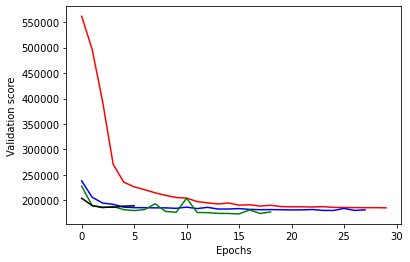

In [24]:
### using MAE works better since there are many outlier home prices
plt.plot(model_1_training.history['val_loss'], 'r', model_2_training.history['val_loss'], 'b', 
         model_3_training.history['val_loss'], 'g', model_4_training.history['val_loss'], 'black')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [25]:
print(model_1.evaluate(x=X_test, y=y_test))
print(model_2.evaluate(x=X_test, y=y_test))
print(model_3.evaluate(x=X_test, y=y_test))
print(model_4.evaluate(x=X_test, y=y_test))

#### This suggests more nodes is better

7606/7606 [==============================] - 1s 164us/sample - loss: 186215.7371
186215.737066132
7606/7606 [==============================] - 1s 147us/sample - loss: 181736.6079
181736.60793699053
7606/7606 [==============================] - 2s 249us/sample - loss: 177287.8130
177287.8129930318
7606/7606 [==============================] - 1s 106us/sample - loss: 192886.7516
192886.75163111358


In [26]:
model_5 = Sequential()
#5th add more nodes and another layer
model_5.add(Dense(300, activation='relu', input_shape=(n_cols,)))
model_5.add(Dense(300, activation='relu'))
model_5.add(Dense(200, activation='relu'))
model_5.add(Dense(1))
model_5.compile(optimizer='adam', loss='mean_absolute_error')
model_5_training = model_5.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])


Train on 15971 samples, validate on 6845 samples
Epoch 1/30
15971/15971 [==============================] - 10s 612us/sample - loss: 264529.3193 - val_loss: 186891.4781
Epoch 2/30
15971/15971 [==============================] - 9s 541us/sample - loss: 193063.6846 - val_loss: 183461.9326
Epoch 3/30
15971/15971 [==============================] - 7s 426us/sample - loss: 189935.8619 - val_loss: 181616.9399
Epoch 4/30
15971/15971 [==============================] - 5s 288us/sample - loss: 190079.8039 - val_loss: 179411.6975
Epoch 5/30
15971/15971 [==============================] - 6s 394us/sample - loss: 186358.5826 - val_loss: 183306.2920
Epoch 6/30
15971/15971 [==============================] - 4s 239us/sample - loss: 184933.5740 - val_loss: 178840.8617
Epoch 7/30
15971/15971 [==============================] - 3s 213us/sample - loss: 183380.5888 - val_loss: 176720.0659
Epoch 8/30
15971/15971 [==============================] - 4s 272us/sample - loss: 187074.8504 - val_loss: 176857.7450
Epoch 

7606/7606 [==============================] - 0s 60us/sample - loss: 186215.7371
186215.737066132
7606/7606 [==============================] - 2s 217us/sample - loss: 181736.6079
181736.60793699053
7606/7606 [==============================] - 1s 85us/sample - loss: 177287.8130
177287.8129930318
7606/7606 [==============================] - 1s 118us/sample - loss: 192886.7516
192886.75163111358
7606/7606 [==============================] - 2s 231us/sample - loss: 117724.6940
117724.69399980278


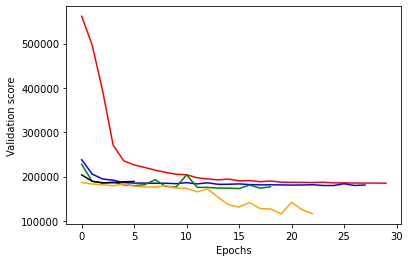

In [27]:
print(model_1.evaluate(x=X_test, y=y_test))
print(model_2.evaluate(x=X_test, y=y_test))
print(model_3.evaluate(x=X_test, y=y_test))
print(model_4.evaluate(x=X_test, y=y_test))
print(model_5.evaluate(x=X_test, y=y_test))

plt.plot(model_1_training.history['val_loss'], 'r', model_2_training.history['val_loss'], 'b', 
         model_3_training.history['val_loss'], 'g', model_4_training.history['val_loss'], 'black',
         model_5_training.history['val_loss'], 'orange')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [28]:
model_6 = Sequential()
#5th add more nodes and another layer
model_6.add(Dense(500, activation='relu', input_shape=(n_cols,)))
model_6.add(Dense(500, activation='relu'))
model_6.add(Dense(500, activation='relu'))
model_6.add(Dense(500, activation='relu'))
model_6.add(Dense(1))
model_6.compile(optimizer='adam', loss='mean_absolute_error')
model_6_training = model_6.fit(X_train, y_train, validation_split=0.3, epochs = 30, callbacks=[early_stopping_monitor])
print(model_6.evaluate(x=X_test, y=y_test))

"""model 5 appears to still be the best, but has 100k error"""

Train on 15971 samples, validate on 6845 samples
Epoch 1/30
15971/15971 [==============================] - 21s 1ms/sample - loss: 262939.6516 - val_loss: 191229.6555
Epoch 2/30
15971/15971 [==============================] - 17s 1ms/sample - loss: 192982.3525 - val_loss: 183097.0203
Epoch 3/30
15971/15971 [==============================] - 17s 1ms/sample - loss: 187722.2807 - val_loss: 193212.6327
Epoch 4/30
15971/15971 [==============================] - 17s 1ms/sample - loss: 194198.6328 - val_loss: 197720.1969
Epoch 5/30
15971/15971 [==============================] - 17s 1ms/sample - loss: 192935.6085 - val_loss: 175845.5904
Epoch 6/30
15971/15971 [==============================] - 18s 1ms/sample - loss: 185195.1038 - val_loss: 180695.0403
Epoch 7/30
15971/15971 [==============================] - 18s 1ms/sample - loss: 184756.2792 - val_loss: 184068.2036
Epoch 8/30
15971/15971 [==============================] - 19s 1ms/sample - loss: 180018.2701 - val_loss: 173297.0200
Epoch 9/30
1597

'model 5 appears to still be the best, but has 100k error'

In [29]:
"""try with dropout instead of early stopping for regularization"""
from tensorflow.keras.layers import Dropout

model_7 = Sequential()
model_7.add(Dense(300, activation='relu', input_shape=(n_cols,)))
model_7.add(Dense(300, activation='relu'))
model_7.add(Dense(200, activation='relu'))
model_7.add(Dropout(0.2))
model_7.add(Dense(1))
model_7.compile(optimizer='adam', loss='mean_absolute_error')
model_7_training = model_7.fit(X_train, y_train, validation_split=0.3, epochs = 20)

Train on 15971 samples, validate on 6845 samples
Epoch 1/20
15971/15971 [==============================] - 4s 250us/sample - loss: 286355.8732 - val_loss: 197648.5871
Epoch 2/20
15971/15971 [==============================] - 3s 192us/sample - loss: 197493.9895 - val_loss: 184771.0613
Epoch 3/20
15971/15971 [==============================] - 4s 272us/sample - loss: 198696.2628 - val_loss: 212052.9685
Epoch 4/20
15971/15971 [==============================] - 4s 261us/sample - loss: 207954.4508 - val_loss: 196978.6602
Epoch 5/20
15971/15971 [==============================] - 3s 191us/sample - loss: 189745.8600 - val_loss: 181214.5500
Epoch 6/20
15971/15971 [==============================] - 4s 235us/sample - loss: 192674.9799 - val_loss: 180361.7997
Epoch 7/20
15971/15971 [==============================] - 5s 319us/sample - loss: 187877.0921 - val_loss: 179249.6457
Epoch 8/20
15971/15971 [==============================] - 5s 301us/sample - loss: 182132.1165 - val_loss: 175046.7967
Epoch 9

7606/7606 [==============================] - 0s 34us/sample - loss: 186215.7371
186215.737066132
7606/7606 [==============================] - 0s 28us/sample - loss: 181736.6079
181736.60793699053
7606/7606 [==============================] - 0s 41us/sample - loss: 177287.8130
177287.8129930318
7606/7606 [==============================] - 0s 41us/sample - loss: 192886.7516
192886.75163111358
7606/7606 [==============================] - 0s 60us/sample - loss: 117724.6940
117724.69399980278
7606/7606 [==============================] - 1s 138us/sample - loss: 121174.6629
121174.66285662635
7606/7606 [==============================] - 0s 47us/sample - loss: 177964.7054
177964.70538472917


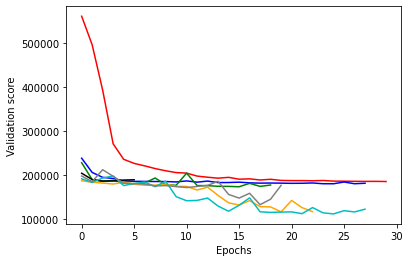

In [32]:
print(model_1.evaluate(x=X_test, y=y_test))
print(model_2.evaluate(x=X_test, y=y_test))
print(model_3.evaluate(x=X_test, y=y_test))
print(model_4.evaluate(x=X_test, y=y_test))
print(model_5.evaluate(x=X_test, y=y_test))
print(model_6.evaluate(x=X_test, y=y_test))
print(model_7.evaluate(x=X_test, y=y_test))

plt.plot(model_1_training.history['val_loss'], 'r', model_2_training.history['val_loss'], 'b', 
         model_3_training.history['val_loss'], 'g', model_4_training.history['val_loss'], 'black',
         model_5_training.history['val_loss'], 'orange', model_6_training.history['val_loss'], 'c',
         model_7_training.history['val_loss'], 'grey')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [38]:
""" try with XGBoost instead """
import lightgbm as lgbm

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    'max_depth': 8,
    'num_leaves': 128,  
    'max_bin': 512,
    'n_estimators': 1000
}

gbm = lgbm.LGBMRegressor(**hyper_params)



In [39]:
gbm.fit(X_train, y_train,
        eval_metric='l1')

C:\Users\patno_000\Anaconda3.1\envs\tf_testing\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8, n_estimators=1000,
              num_iterations=10000, num_leaves=128, objective='regression',
              task='train', verbose=0)

In [40]:
y_pred = gbm.predict(X_test)

In [43]:
print(X_test.shape)
print(y_pred.shape)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, )

(7606, 106)
(7606,)
